# Release Highlights for scikit-learn 0.22

## New plotting API
- 새로운 API는 어떤 재계산을 포함하지 않고 plot의 시각화를 조정할 수 있다.
- 같은 figure에 다른 plot을 추가하는 것도 가능하다.

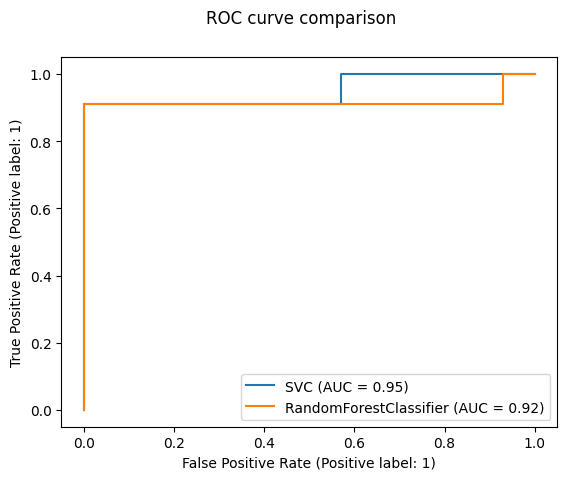

In [2]:
import matplotlib.pyplot as plt 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# ploc_roc_curve는 version 1.2에서 제거 되었다. 1.2에서부터는 RocCurveDisplay가 대신 사용된다.
# svc_disp = plot_roc_curve(svc, X_test, y_test)
# rfc_disp = plot_roc_curve(rfc, X_test, y_test)
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=svc_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")

plt.show()


## Stacking Classifier and Regressor

In [3]:
from sklearn.datasets import load_iris
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

X, y = load_iris(return_X_y=True)
estimators = [
    ("rf", RandomForestClassifier(n_estimators=10, random_state=42)),
    ("svr", make_pipeline(StandardScaler(), LinearSVC(random_state=42))),
]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Cal-01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

0.9473684210526315

## Permutation-based feature importance

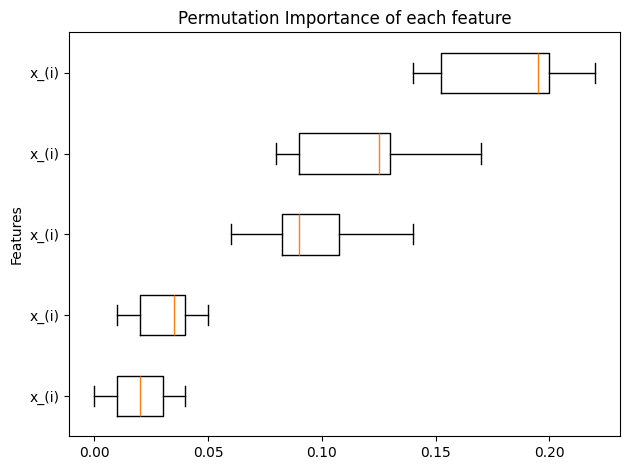

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

X, y = make_classification(random_state=0, n_features=5, n_informative=3)
feature_names = np.array([f"x_(i)" for i in range(X.shape[1])])

rf = RandomForestClassifier(random_state=0).fit(X, y)
result = permutation_importance(rf, X, y, n_repeats=10, random_state=0, n_jobs=2)

fig, ax = plt.subplots()
sorted_idx = result.importances_mean.argsort()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

## Naive support for missing values for gradient boosting

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier

X = np.array([0, 1, 2, np.nan]).reshape(-1, 1)
y = [0, 0, 1, 1]

gbdt = HistGradientBoostingClassifier(min_samples_leaf=1).fit(X, y)
print(gbdt.predict(X))

[0 0 1 1]


## Precomputed sparse nearest neighbors graph

In [8]:
from tempfile import TemporaryDirectory

from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsTransformer
from sklearn.pipeline import make_pipeline

X, y = make_classification(random_state=0)

with TemporaryDirectory(prefix="sklearn_cache_") as tmpdir:
    estimator = make_pipeline(
        KNeighborsTransformer(n_neighbors=10, mode="distance"),
        Isomap(n_neighbors=10, metric="precomputed"),
        memory=tmpdir
    )
    estimator.fit(X)

    # neighbors의 수를 줄일 수 있고, graph는 다시 계산되지 않는다.
    estimator.set_params(isomap__n_neighbors=5)
    estimator.fit(X)

## KNN Based Imputation

In [9]:
from sklearn.impute import KNNImputer

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2)
print(imputer.fit_transform(X))

[[1.  2.  4. ]
 [3.  4.  3. ]
 [5.5 6.  5. ]
 [8.  8.  7. ]]


## Tree pruning

In [10]:
X, y = make_classification(random_state=0)

rf = RandomForestClassifier(random_state=0, ccp_alpha=0).fit(X, y)
print("Average number of nodes without pruning {:.1f}".format(np.mean([e.tree_.node_count for e in rf.estimators_])))

rf = RandomForestClassifier(random_state=0, ccp_alpha=0.05).fit(X, y)
print("Average number of nodes with pruning {:.1f}".format(np.mean([e.tree_.node_count for e in rf.estimators_])))

Average number of nodes without pruning 22.3
Average number of nodes with pruning 6.4


## Retrieve dataframes form OpenML

In [11]:
from sklearn.datasets import fetch_openml

titanic = fetch_openml("titanic", version=1, as_frame=True, parser="pandas")
print(titanic.data.head()[["pclass", "embarked"]])

   pclass embarked
0       1        S
1       1        S
2       1        S
3       1        S
4       1        S


## Checking scikit-learn compatibility of an estimator

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.estimator_checks import parametrize_with_checks


@parametrize_with_checks([LogisticRegression(), DecisionTreeRegressor()])
def test_sklearn_compatible_estimator(estimator, check):
    check(estimator)

## ROC AUC now supports multiclass classfication

In [15]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

X, y = make_classification(n_classes=4, n_informative=16)
clf = SVC(decision_function_shape="ovo", probability=True).fit(X, y)
print(roc_auc_score(y, clf.predict_proba(X), multi_class="ovo"))

0.9795999999999999
